#### Instructions
###### Follow the instructions given in comments prefixed with ## and write your code below that.
###### Also fill the partial code in given blanks. 
###### Don't make any changes to the rest part of the codes

### Answer the questions given at the end of this notebook within your report.


### You would need to submit your GitHub repository link. Refer to the Section 6: Final Submission on the PDF document for the details.


In [3]:
!pip install numpy pandas scikit-learn wandb python-dotenv

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from dotenv import load_dotenv
import os

load_dotenv
wandb_api = os.getenv("WANDB_API")
import wandb
wandb.login(key=wandb_api)

wandb.init(project = 'distance_classification_proj')

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import silhouette_score


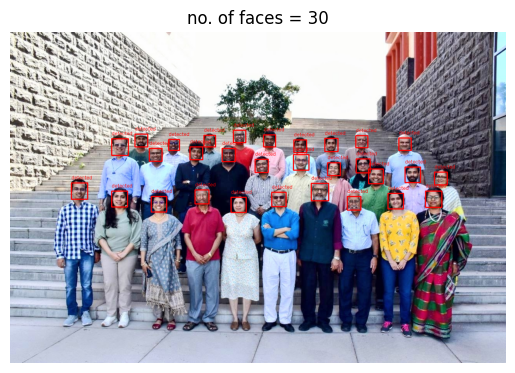

In [17]:
## Reading the image plaksha_Faculty.jpg

faculty = cv2.imread('Plaksha_Faculty.jpg')
shashi = cv2.imread('Dr_Shashi_Tharoor.jpg')
  
## Convert the image to grayscale
gray_img = cv2.cvtColor(faculty, cv2.COLOR_BGR2GRAY)
  
# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  
# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))
 
# Define the text and font parameters
text = "detected" ## The text you want to write
font = cv2.FONT_HERSHEY_SIMPLEX  ## Font type
font_scale = 0.4  ## Font scale factor
font_color = (0, 0, 255)  ## Text color in BGR format (here, it's red)
font_thickness = 1  ## Thickness of the text

  
# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(faculty, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(faculty, text, (x, y-10), font, font_scale, font_color, font_thickness)
    
## Display the image and window title should be "Total number of face detected are #"  
plt.imshow(cv2.cvtColor(faculty, cv2.COLOR_BGR2RGB))
plt.title(f"no. of faces = {len(faces_rect)}")
plt.axis("off")
plt.savefig('faculty_detected.jpg')
plt.show()
wandb.log({'Faculty faces detcted': wandb.Image('faculty_detected.jpg')})

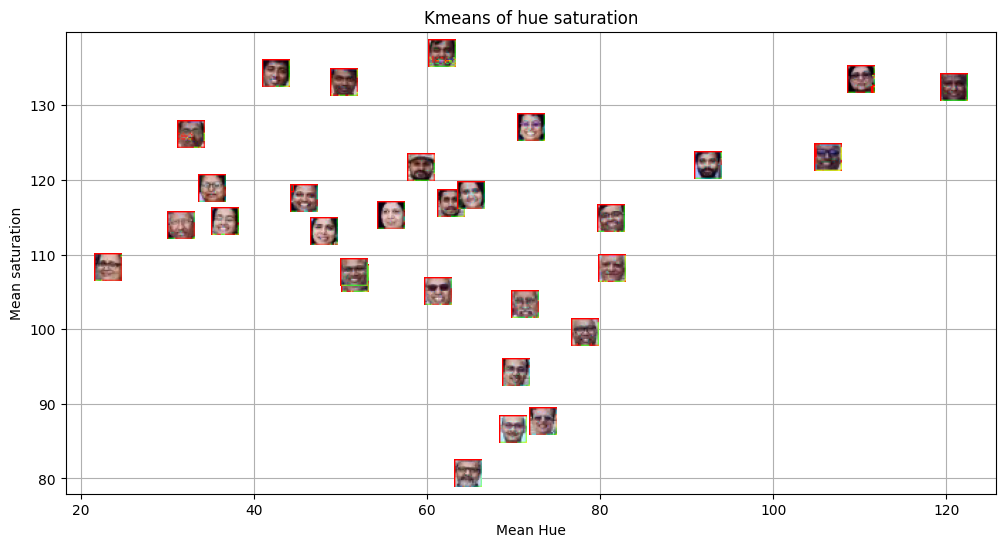

In [18]:

# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(faculty, cv2.COLOR_BGR2HSV) ## call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(hue_saturation)
#centroids = kmeans.cluster_centers_
#labels = kmeans.labels_

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x,y,w,h ) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])
    

## Put x label
plt.xlabel('Mean Hue')
## Put y label
plt.ylabel('Mean saturation')
## Put title
plt.title('Kmeans of hue saturation')
## Put grid
plt.grid(True)
## show the plot
plt.savefig('faculty_plt.jpg')
plt.show()
wandb.log({'Faculy Image plot': wandb.Image('faculty_plt.jpg')})

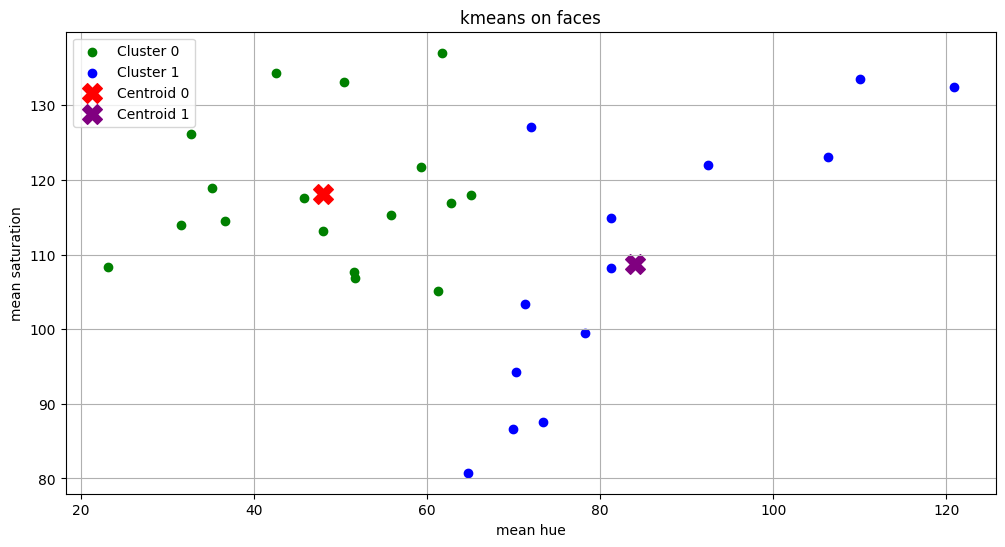

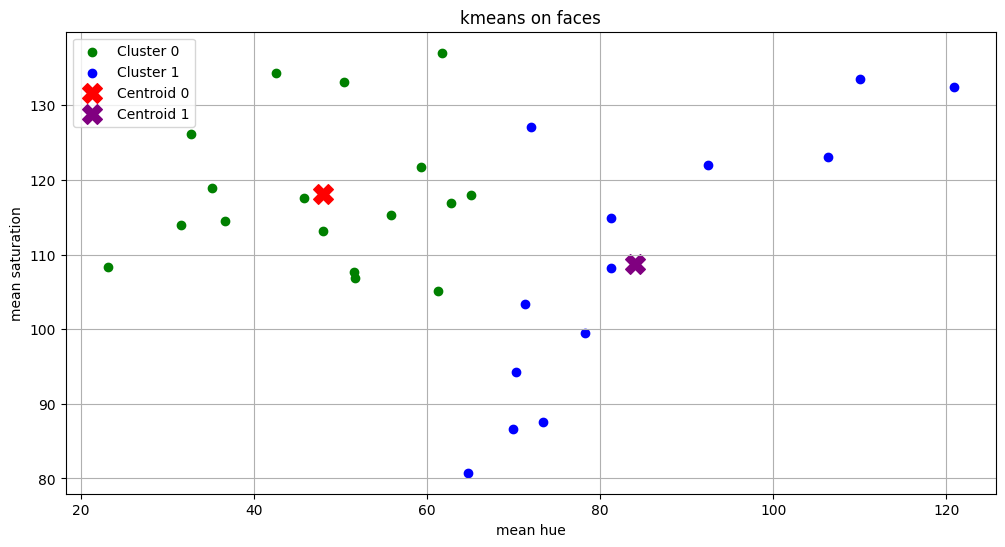

In [19]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))


cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label="Cluster 0")

cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label="Cluster 1")

# Calculate and plot centroids
centroid_0 = kmeans.cluster_centers_[0]
centroid_1 = kmeans.cluster_centers_[1]

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], color='red', marker='X', s=200, label="Centroid 0")
plt.scatter(centroid_1[0], centroid_1[1], color='purple', marker='X', s=200, label="Centroid 1")
## Put x label
plt.xlabel('mean hue')
## Put y label
plt.ylabel('mean saturation')
## Put title
plt.title('kmeans on faces')
## Add a legend
plt.legend()
## Add grid
plt.grid(True)
## Show the plot
plt.savefig('faculty_cluster.jpg')
plt.show(0)
wandb.log({'Faculty clusters plot': wandb.Image('faculty_cluster.jpg')})


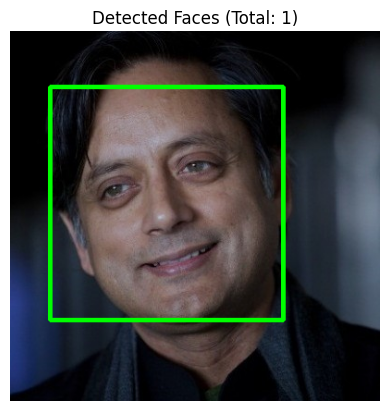

In [20]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = shashi
# Detect face  in the template image after converting it to gray and store it in template_faces
gray_template = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_faces = face_cascade.detectMultiScale(gray_template, scaleFactor=1.1, minNeighbors=4)
# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
plt.imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Faces (Total: {len(template_faces)})")
plt.axis("off")
plt.savefig('shashi_detected.jpg')
plt.show()     
wandb.log({'Shashi Tharoor Detected': wandb.Image('shashi_detected.jpg')})

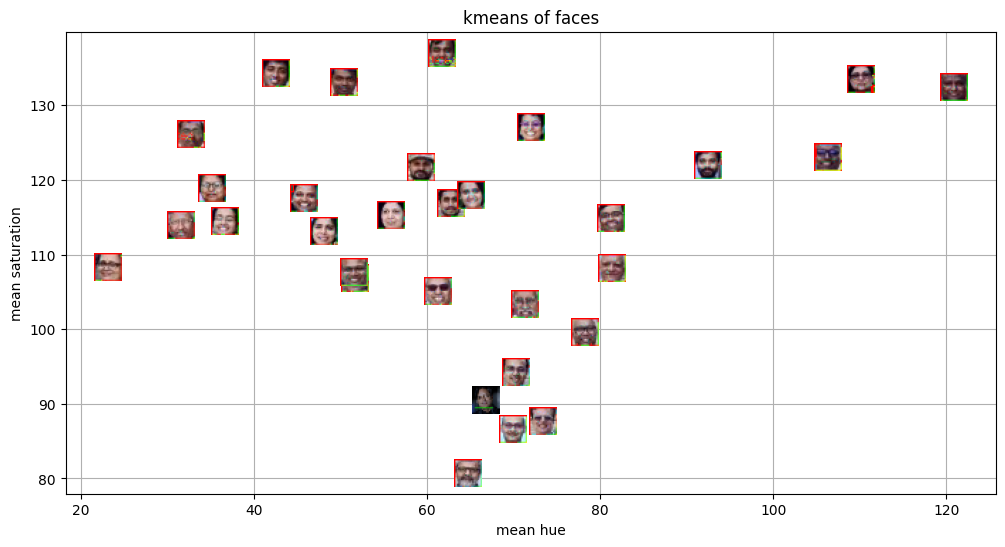

In [21]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)
# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0]) 
template_saturation = np.mean(template_hsv[:, :, 1]) 

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

## Put x label
plt.xlabel('mean hue')
## Put y label
plt.ylabel('mean saturation')
## Put title
plt.title('kmeans of faces')
## Add grid
plt.grid(True)
## show plot
plt.savefig('shashi_plot.jpg')
plt.show()
wandb.log({'Shashi Tharoor in faculty plot': wandb.Image('shashi_plot.jpg')})

In [11]:
print(template_label)

1


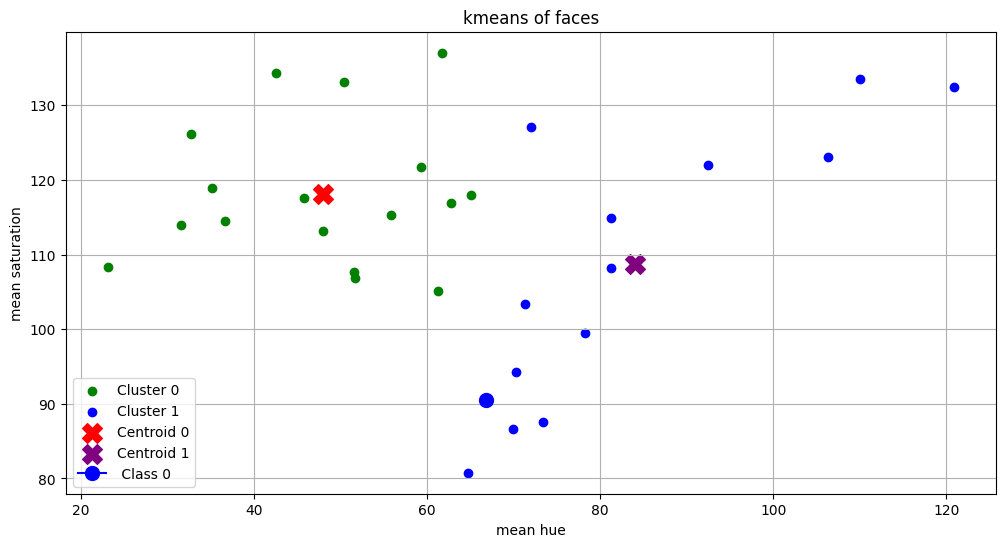

In [22]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label="Cluster 0")

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label="Cluster 1")


# Calculate and plot centroids for both the clusters
centroid_0 = kmeans.cluster_centers_[0]  
centroid_1 = kmeans.cluster_centers_[1] 
plt.scatter(centroid_0[0], centroid_0[1], color='red', marker='X', s=200, label="Centroid 0")
plt.scatter(centroid_1[0], centroid_1[1], color='purple', marker='X', s=200, label="Centroid 1")
plt.plot(template_hue, template_saturation, marker='o', c= 'blue',markersize= 10, label=' Class 0' )

## Put x label
plt.xlabel('mean hue')
## Put y label
plt.ylabel('mean saturation')
## Put title
plt.title('kmeans of faces')
## Add grid
plt.grid(True)
plt.legend()
## show plot
plt.savefig('shashi_cluster.jpg')
plt.show()
wandb.log({'Shashi Tharoor in cluster': wandb.Image('shashi_cluster.jpg')})
                                            ## End of the lab 5 ##

## Report:
## Answer the following questions within your report:


#### 1. What are the common distance metrics used in distance-based classification algorithms? 

#### 2. What are some real-world applications of distance-based classification algorithms? 

#### 3. Explain various distance metrics. 

#### 4. What is the role of cross validation in model performance? 

#### 5. Explain variance and bias in terms of KNN? 

1. Common distance metrics used in kmeans are euclidian, manhattan mahalanobis and more
2. real world applications of distance based algos include faces detection, image matching spam detction and more
3. euclidian - It is the root of the sum of x^2 + y^2 or the length of the line between two point, manhattan is the sum of the x difference and y difference and mahalanobis checks distance of a point from a distibution
4. Cross validation allows us to check and fine tune model performance using validation sets before finalizing on a model
5. Bias is low and variance is high when we have a small k or the model overfits, bias is high and variance is low when we have a really large k or the model underfits